# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def open_img(img_fname: str) -> np.array:
    image = Image.open(img_fname)
    return np.array(image)

def show_img(image: np.array) -> None:
    fig = plt.figure(figsize=(14, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def depth_to_heatmap(depht_arr: np.array, reverse: bool = True) -> np.array:
    colormap = plt.get_cmap('inferno')
    depht_arr = depht_arr / depht_arr.max()
    
    if reverse:
        mask = np.ma.masked_where(depht_arr==0, depht_arr)
        depht_arr = 1 - depht_arr
        depht_arr[mask.mask] = 0

    heatmap = colormap(depht_arr)
    return heatmap

# Evo data

# Monodepth2

In [2]:
import sys
from pathlib import Path

repo_dir = Path().resolve() / "networks/monodepth2"
sys.path.insert(0, repo_dir.as_posix())

## Options

In [3]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class Options:
    # PATHS
    data_path: str
    log_dir: str = (repo_dir / "tmp").as_posix()
    
    # TRAINING options
    model_name: str = (repo_dir / "mdp").as_posix()
    split: str = "eigen_zhou"
    num_layers: int = 18
    dataset: str = "kitti"
    png: bool = False
    height: int = 192
    width: int = 640
    disparity_smoothness: float = 1e-3
    scales: Tuple = (0, 1, 2, 3, 4)
    min_depth: float = 0.1
    max_depth: float = 100.0
    use_stereo: bool = False
    frame_ids: Tuple[int] = (-1, 0, 1)

    # OPTIMIZATION options
    batch_size: int = 1 # 12
    learning_rate: float = 1e4
    num_epochs: int = 20
    scheduler_step_size: int = 15
    
    # SYSTEM options
    no_cuda: bool = False
    num_workers: int = 12
        
    # ABLATION options
    weights_init: str = "pretrained"
        
     # LOADING options
    load_weights_folder: str = repo_dir / "models/mono_640x192"
    models_to_load: Tuple[str] = ("encoder", "depth")
    
data_path = Path().resolve() / "datasets/bags_historical"     
data_path = Path("/data/dvkorshunov/datasets/kitti")
opt = Options(data_path=data_path.as_posix())
opt

Options(data_path='/data/dvkorshunov/datasets/kitti', log_dir='/home/dvkorshunov/mono_depth/monocular_depth_estimation/networks/monodepth2/tmp', model_name='/home/dvkorshunov/mono_depth/monocular_depth_estimation/networks/monodepth2/mdp', split='eigen_zhou', num_layers=18, dataset='kitti', png=False, height=192, width=640, disparity_smoothness=0.001, scales=(0, 1, 2, 3, 4), min_depth=0.1, max_depth=100.0, use_stereo=False, frame_ids=(-1, 0, 1), batch_size=1, learning_rate=10000.0, num_epochs=20, scheduler_step_size=15, no_cuda=False, num_workers=12, weights_init='pretrained', load_weights_folder=PosixPath('/home/dvkorshunov/mono_depth/monocular_depth_estimation/networks/monodepth2/models/mono_640x192'), models_to_load=('encoder', 'depth'))

## Dataset

## Dataloader

In [4]:
from torch.utils.data import DataLoader
from datasets import KITTIRAWDataset
from utils import readlines


train_filenames = readlines(repo_dir /f"splits/{opt.split}/train_files.txt")
opt.png = True
img_ext = ".png" if opt.png else ".jpg"

train_dataset = KITTIRAWDataset(
    data_path=opt.data_path, 
    filenames=train_filenames, 
    height=opt.height, 
    width=opt.width,
    frame_idxs=opt.frame_ids, 
    num_scales=4, 
    img_ext=img_ext,
    is_train=True, 
)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=opt.batch_size, 
    shuffle=True,
    num_workers=opt.num_workers, 
    pin_memory=True, 
    drop_last=True
)

/home/dvkorshunov/miniconda/envs/py37/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


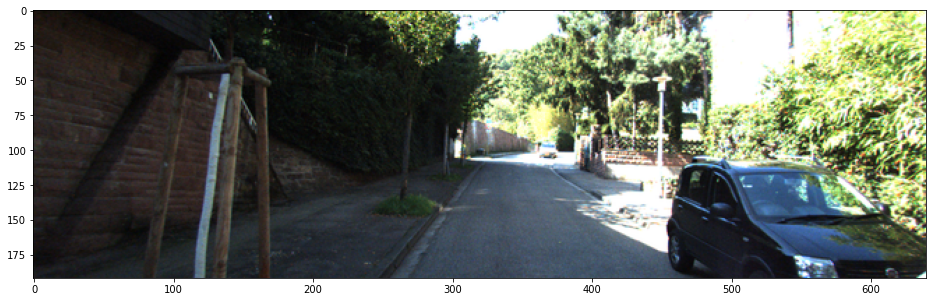

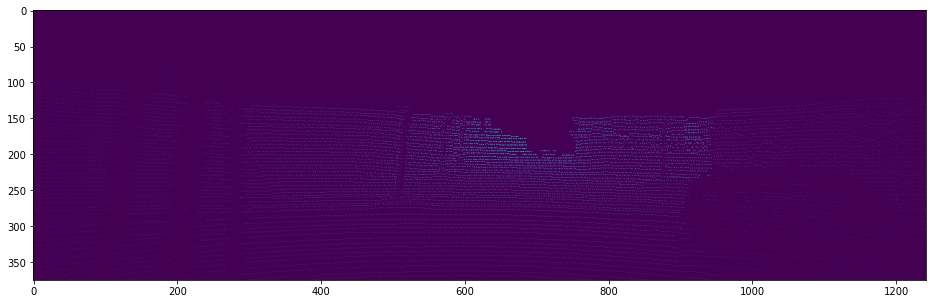

In [5]:
data = train_dataset[15000]
depth_data = data["depth_gt"].numpy().squeeze()
pre_img = data[('color', -1, 0)].numpy().transpose((1, 2, 0)) 

import matplotlib.pyplot as plt

arr = [pre_img, depth_data]
for img in arr:
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.show()

## Network

In [6]:
import torch
import numpy as np
# import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import DataLoader
# from tensorboardX import SummaryWriter


import networks


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {}
parameters_to_train = []

models["encoder"] = networks.ResnetEncoder(opt.num_layers, opt.weights_init == "pretrained")
models["encoder"].to(device)
parameters_to_train += list(models["encoder"].parameters())

models["depth"] = networks.DepthDecoder(models["encoder"].num_ch_enc, opt.scales)
models["depth"].to(device)
parameters_to_train += list(models["depth"].parameters())

In [7]:
import os

def load_model(opt, models):
    """Load model(s) from disk
    """
    opt.load_weights_folder = os.path.expanduser(opt.load_weights_folder)

    assert os.path.isdir(opt.load_weights_folder), \
        "Cannot find folder {}".format(opt.load_weights_folder)
    print("loading model from folder {}".format(opt.load_weights_folder))

    for n in opt.models_to_load:
        print("Loading {} weights...".format(n))
        path = os.path.join(opt.load_weights_folder, "{}.pth".format(n))
        model_dict = models[n].state_dict()
        pretrained_dict = torch.load(path)
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        models[n].load_state_dict(model_dict)

In [8]:
model_optimizer = optim.Adam(parameters_to_train, opt.learning_rate)
model_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer=model_optimizer, 
    step_size=opt.scheduler_step_size, 
    gamma=0.1
)

if opt.load_weights_folder is not None:
    load_model(opt, models)

print("Training model named:\n  ", opt.model_name)
print("Models and tensorboard events files are saved to:\n  ", opt.log_dir)
print("Training is using:\n  ", device)

loading model from folder /home/dvkorshunov/mono_depth/monocular_depth_estimation/networks/monodepth2/models/mono_640x192
Loading encoder weights...
Loading depth weights...
Training model named:
   /home/dvkorshunov/mono_depth/monocular_depth_estimation/networks/monodepth2/mdp
Models and tensorboard events files are saved to:
   /home/dvkorshunov/mono_depth/monocular_depth_estimation/networks/monodepth2/tmp
Training is using:
   cuda


## Train

In [9]:
iterator = iter(train_loader)
for batch_idxin in range(len(train_loader)):
    try:
        inputs = next(iterator)
    except (FileNotFoundError, TypeError) as err:
        continue
    img = inputs[("color_aug", 0, 0)].to(device)
    features = models["encoder"](img)
    outputs = models["depth"](features)
    break


RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 10.76 GiB total capacity; 141.83 MiB already allocated; 5.56 MiB free; 152.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
features = models["encoder"](data[("color_aug", 0, 0)].unsqueeze(0).to(device))
outputs = models["depth"](features)

In [ ]:
depth_tmp = outputs[('disp', 0)].squeeze().cpu().detach().numpy()
depth_tmp.max()

In [ ]:
plt.figure(figsize=(14,8))
plt.imshow(depth_tmp)
plt.show()

In [ ]:
dataюлу

In [ ]:
img = data[("color_aug", 0, 0)].numpy().transpose((1,2,0))
plt.figure(figsize=(14,8))
plt.imshow(img)
plt.show()
img = data["depth_gt"].numpy().transpose((1,2,0)).squeeze()
heatmap = depth_to_heatmap(img)
plt.figure(figsize=(14,8))
plt.imshow(heatmap)
plt.show()

## 